In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly



In [4]:
code = 'KEL'
filename = lambda x: f'stockdata/{x}.csv'
read = filename(code)

df = pd.read_csv(read,delimiter='\t',header=None)
df.columns = ['Time','Open','High','Low','Close','Volume']
df['Time'] = pd.to_datetime(df['Time'],infer_datetime_format=True)
df.set_index('Time',inplace=True)
df = df[['Close']]

In [5]:
train_end = datetime(2022,11,30).date()
train_data = df[:train_end]
test_data = df[train_end+timedelta(days=1):]

In [6]:
adfuller(df)

(-2.4228493464751013,
 0.13539092326015012,
 1,
 729,
 {'1%': -3.4393520240470554,
  '5%': -2.8655128165959236,
  '10%': -2.5688855736949163},
 -1379.415889509769)

<AxesSubplot: xlabel='Time'>

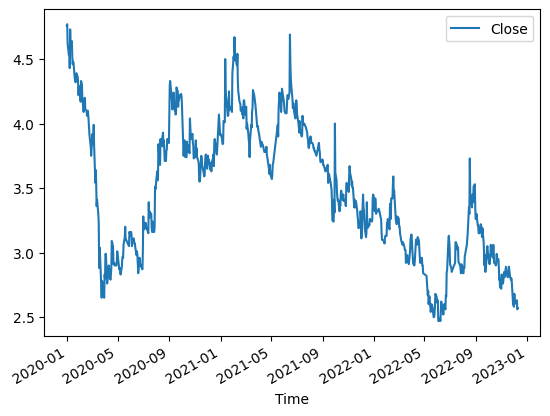

In [7]:
df.plot()

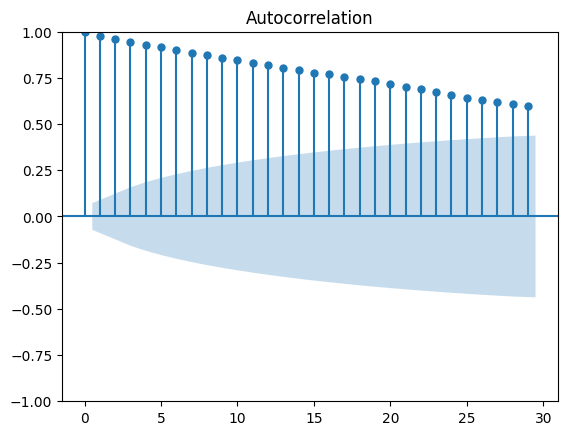

In [8]:
acf = plot_acf(df)

/home/daniyal/working/envs/timeseries/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


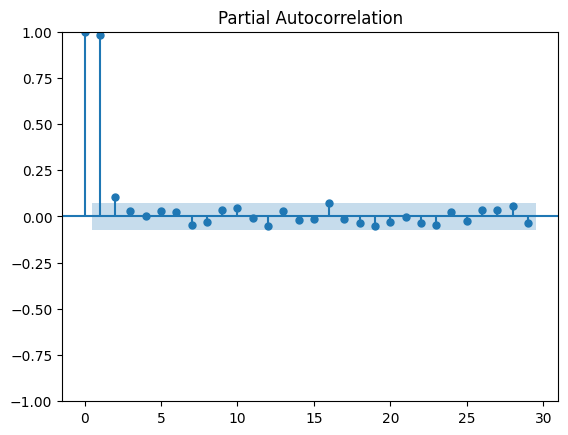

In [9]:
pacf = plot_pacf(df)

In [21]:
train_data.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-06',
               '2020-01-07', '2020-01-08', '2020-01-09', '2020-01-10',
               '2020-01-13', '2020-01-14',
               ...
               '2022-11-17', '2022-11-18', '2022-11-21', '2022-11-22',
               '2022-11-23', '2022-11-24', '2022-11-25', '2022-11-28',
               '2022-11-29', '2022-11-30'],
              dtype='datetime64[ns]', name='Time', length=724, freq=None)

Data is related to stock, we can not skip any lag

AR Model

In [10]:
auto_reg_model = AutoReg(train_data,lags=1)
auto_reg_fit = auto_reg_model.fit()
auto_reg_fit.summary()


/home/daniyal/working/envs/timeseries/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                  Close   No. Observations:                  724
Model:                     AutoReg(1)   Log Likelihood                 694.592
Method:               Conditional MLE   S.D. of innovations              0.093
Date:                Wed, 21 Dec 2022   AIC                          -1383.184
Time:                        17:18:36   BIC                          -1369.433
Sample:                             1   HQIC                         -1377.876
                                  724                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0592      0.023      2.549      0.011       0.014       0.105
Close.L1       0.9822      0.007    149.261      0.000       0.969       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0182           +0.0000j            1.0182            0.0000
-----------------------------------------------------------------------------
"""

Prophet Model

In [22]:
prophet_model = Prophet()
_df = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data['Close'].values
})
prophet_model.fit(_df)

17:23:11 - cmdstanpy - INFO - Chain [1] start processing
17:23:11 - cmdstanpy - INFO - Chain [1] done processing


In [24]:
future = prophet_model.make_future_dataframe(periods=3)
future.tail()


,ds
722,2022-11-29
723,2022-11-30
724,2022-12-01
725,2022-12-02
726,2022-12-03


In [25]:
forecast = prophet_model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
722,2022-11-29,2.659759,2.451791,2.867176
723,2022-11-30,2.657626,2.455894,2.858931
724,2022-12-01,2.657289,2.469459,2.866000
725,2022-12-02,2.643593,2.450745,2.843041
726,2022-12-03,2.794459,2.604098,2.977999


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

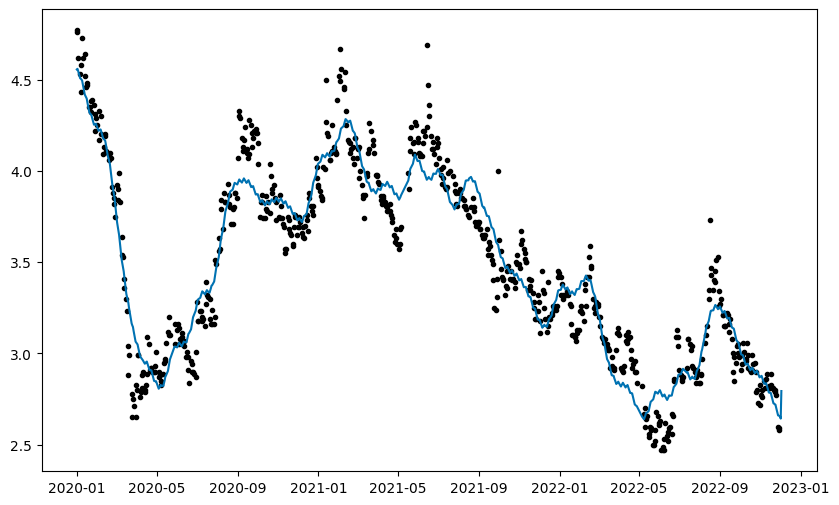

In [26]:
fig1 = prophet_model.plot(forecast)

TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

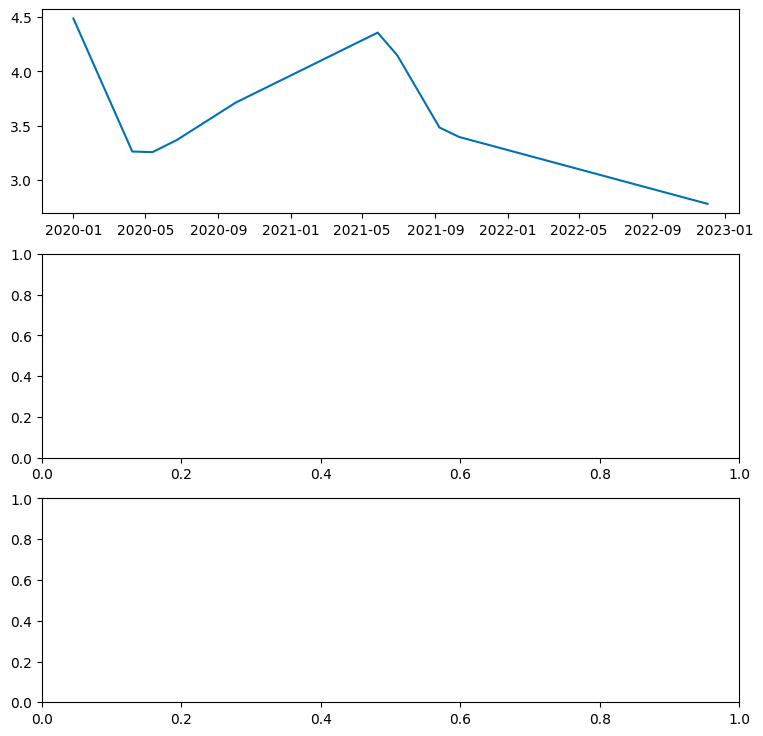

In [27]:
fig2 = prophet_model.plot_components(forecast)

In [29]:
plot_components_plotly(prophet_model, forecast)


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'trend',
              'type': 'scatter',
              'x': array([datetime.datetime(2020, 1, 1, 0, 0),
                          datetime.datetime(2020, 1, 2, 0, 0),
                          datetime.datetime(2020, 1, 3, 0, 0), ...,
                          datetime.datetime(2022, 12, 1, 0, 0),
                          datetime.datetime(2022, 12, 2, 0, 0),
                          datetime.datetime(2022, 12, 3, 0, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([4.48442964, 4.47209879, 4.45976793, ..., 2.78652788, 2.78505909,
                          2.78359031]),
              'yaxis': 'y'},
             {'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'yearly',
              'type': 'scatter',
              'x': array([datetime.datetime(2017, 1, 1, 0, 0),
                          datetime.datetime(2017, 1, 2, 0, 0, 59, 178082),
                          datetime.datetime(2017, 1, 3, 0, 1, 58, 356164), ...,
                          datetime.datetime(2017, 12, 29, 5, 57, 2, 465753),
                          datetime.datetime(2017, 12, 30, 5, 58, 1, 643835),
                          datetime.datetime(2017, 12, 31, 5, 59, 0, 821917)], dtype=object),
              'xaxis': 'x2',
              'y': array([0.12107773, 0.12805097, 0.13383679, ..., 0.09340083, 0.10369158,
                          0.11294153]),
              'yaxis': 'y2'},
             {'line': {'color': '#0072B2', 'width': 2},
              'mode': 'lines',
              'name': 'weekly',
              'type': 'scatter',
              'x': array([datetime.datetime(2017, 1, 1, 0, 0),
                          datetime.datetime(2017, 1, 2, 0, 0),
                          datetime.datetime(2017, 1, 3, 0, 0),
                          datetime.datetime(2017, 1, 4, 0, 0),
                          datetime.datetime(2017, 1, 5, 0, 0),
                          datetime.datetime(2017, 1, 6, 0, 0),
                          datetime.datetime(2017, 1, 7, 0, 0)], dtype=object),
              'xaxis': 'x3',
              'y': array([ 0.11539123, -0.05797354, -0.05036548, -0.04393465, -0.03617258,
                          -0.04233618,  0.1153912 ]),
              'yaxis': 'y3'}],
    'layout': {'height': 600,
               'showlegend': False,
               'template': '...',
               'width': 900,
               'xaxis': {'anchor': 'y',
                         'domain': [0.0, 1.0],
                         'range': [2019-11-08 15:36:00, 2023-01-25 08:24:00],
                         'type': 'date'},
               'xaxis2': {'anchor': 'y2',
                          'domain': [0.0, 1.0],
                          'range': [2016-12-13 18:54:02.958904115, 2018-01-18
                                    11:04:57.863013581],
                          'tickformat': '%B %e',
                          'type': 'date'},
               'xaxis3': {'anchor': 'y3',
                          'domain': [0.0, 1.0],
                          'range': [2016-12-31 16:48:00, 2017-01-07 07:12:00],
                          'tickformat': '%A',
                          'type': 'date'},
               'yaxis': {'anchor': 'x',
                         'domain': [0.7333333333333333, 1.0],
                         'rangemode': 'normal',
                         'title': {'text': 'trend'},
                         'zerolinecolor': '#AAA'},
               'yaxis2': {'anchor': 'x2',
                          'domain': [0.36666666666666664, 0.6333333333333333],
                          'title': {'text': 'yearly'},
                          'zerolinecolor': '#AAA'},
               'yaxis3': {'anchor': 'x3',
                          'domain': [0.0, 0.26666666666666666],
                          'title': {'text': 'weekly'},
                          'zerolinecolor': '#AAA'}}
})

LSTM